## Get Data 
1. Read the historical AFL results data from file. 
2. Drop extra cols, drop NA; Keep Scores, Outcomes, and Aggregated Odds.
3. Analyze 

In [ ]:
import pandas as pd 
import json 
import numpy as np
import matplotlib.pyplot as plt
from py.helpers import * 

DATA_FILEPATH = "./data/afl.xlsx"
data = pd.read_excel(DATA_FILEPATH, header=1)
data = data[['Date', 'Home Team', 'Away Team', 'Home Score', 'Away Score', 'Home Odds', 'Away Odds']]
data['Outcomes'] = np.where(data['Home Score'] > data['Away Score'], 1, 0)
data.dropna(subset=['Date', 'Home Odds', 'Away Odds'], inplace=True)
print(f"Data from {data['Date'].min()} to {data['Date'].max()}")
print(f"Total matches: {len(data)}")

Data from 2009-06-19 00:00:00 to 2025-06-22 00:00:00
Total matches: 3264


In [ ]:
def calculate_normmalized_implied_probabilities(actual_odds):
    """
    Calculate implied probabilities from odds.
    
    Args:
        odds (pd.DataFrame): DataFrame containing 'Home Odds' and 'Away Odds'.
        
    Returns:
        pd.DataFrame: DataFrame with implied probabilities for home and away teams.
    """
    actual_probs = 1 / actual_odds
    total_prob = actual_probs.sum(axis=1)
    fair_probs = actual_probs.div(total_prob, axis=0)
    fair_probs.columns = ['Home Probs', 'Away Probs'] 
    fair_odds = 1 / fair_probs
    fair_odds.columns = ['Home Odds', 'Away Odds']
    return fair_odds, fair_probs

def calculate_weighted_implied_probabilities(actual_odds: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate fair odds assuming the bookmaker margin is distributed
    proportionally based on odds — higher odds get less margin.

    Args:
        actual_odds (pd.DataFrame): DataFrame with 'Home Odds' and 'Away Odds'.

    Returns:
        (pd.DataFrame, pd.DataFrame): fair odds and fair probabilities
    """
    implied_probs = 1 / actual_odds
    margin = implied_probs.sum(axis=1) - 1.0  # total bookmaker margin

    # Compute inverse-odds weights (lower odds → more margin share)
    weights = actual_odds.sum(axis=1).values.reshape(-1, 1) / actual_odds.values
    # Normalize weights so each row sums to 1
    normalized_weights = weights / weights.sum(axis=1).reshape(-1, 1)

    # Distribute the margin based on weights
    margin_allocation = normalized_weights * margin.values.reshape(-1, 1)

    fair_probs = implied_probs.values - margin_allocation
    fair_probs_df = pd.DataFrame(fair_probs, columns=['Home Probs', 'Away Probs'])
    fair_odds_df = 1 / fair_probs_df
    fair_odds_df.columns = ['Home Odds', 'Away Odds']

    return fair_odds_df, fair_probs_df

def simulate_favourite_betting_strategy(odds, probs, outcomes, stake=10):
    """
    Simulate a betting strategy where you bet on the favourite team.
    
    Args:
        odds (pd.DataFrame): DataFrame containing 'Home Odds' and 'Away Odds'.
        probs (pd.DataFrame): DataFrame containing 'Home Probs' and 'Away Probs'.
        outcomes (pd.Series): Series with actual outcomes (1 for Home win, 0 for Away).
        stake (int): Amount to bet each time.
        
    Returns:
        np.ndarray: Array of profits for each bet. 
    """
    home_odds = odds["Home Odds"].values
    away_odds = odds["Away Odds"].values

    # Identify the favourite team based on odds
    is_home_favourite = home_odds < away_odds
    favourite_odds = np.where(is_home_favourite, home_odds, away_odds)

    # Determin if favourite team won
    favourite_wins = np.where(is_home_favourite, outcomes, 1 - outcomes)

    # Calculate total winnings
    profits = np.where(favourite_wins, (favourite_odds * stake) - stake, -stake)
    total_wins = np.sum(favourite_wins)

    return profits, total_wins 

def calculate_brier_score(probs, outcomes):
    """
    Calculate the Brier Score for the given probabilities and outcomes.
    """
    # Step 1: Brier Score (2-class: Home vs Away)
    probs = np.vstack([probs['Home Probs'], probs['Away Probs']]).T
    actuals = np.vstack([outcomes, 1 - outcomes]).T
    brier_score = np.mean(np.sum((probs - actuals) ** 2, axis=1))

    return brier_score

def plot_calibration_curve(odds_df, outcomes, n_bins=10, ax=None):
    """
    Plots a calibration curve: implied probability vs actual outcomes.
    
    Parameters:
        odds_df (pd.DataFrame): Columns ["Home Odds", "Away Odds"]
        outcomes (pd.Series): 1 = home win, 0 = away win
        n_bins (int): Number of bins to group probabilities
        ax (matplotlib.axes.Axes, optional): Axis to draw the plot on. If None, creates new.
    
    Returns:
        matplotlib.axes.Axes: The axis with the plotted calibration curve
    """
    assert "Home Odds" in odds_df and "Away Odds" in odds_df

    implied_home_prob = 1 / odds_df["Home Odds"]
    implied_away_prob = 1 / odds_df["Away Odds"]
    total_prob = implied_home_prob + implied_away_prob
    norm_home_prob = implied_home_prob / total_prob

    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(norm_home_prob, bins) - 1

    bin_centers = (bins[:-1] + bins[1:]) / 2
    avg_pred_prob = []
    actual_win_rate = []

    for i in range(n_bins):
        mask = bin_ids == i
        if np.sum(mask) == 0:
            continue
        avg_pred_prob.append(np.mean(norm_home_prob[mask]))
        actual_win_rate.append(np.mean(outcomes[mask]))

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(avg_pred_prob, actual_win_rate, marker='o', label='Observed')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    ax.set_xlabel("Implied Home Win Probability")
    ax.set_ylabel("Observed Home Win Rate")
    ax.set_title("Calibration Plot")
    ax.grid(True)
    ax.legend()
    
    return ax

def plot_cumulative_profit(profits, ax=None):
    """
    Plots cumulative profit over time from a series of betting profits.
    
    Parameters:
        profits (pd.Series): Profit or loss for each bet (level stakes assumed)
        ax (matplotlib.axes.Axes, optional): If provided, plot on this axis
    
    Returns:
        matplotlib.axes.Axes: The axis with the plotted curve
    """
    cumulative_profit = profits.cumsum()
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(cumulative_profit, label="Cumulative Profit", color="blue")
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_xlabel("Bet Number")
    ax.set_ylabel("Cumulative Profit")
    ax.set_title("Cumulative Profit from Level-Stake Betting")
    ax.grid(True)
    ax.legend()
    
    return ax

Brier Score: 0.3873
Total Profit from Betting on Favourites: 169.40
Total Wins: 2280 out of 3264 matches


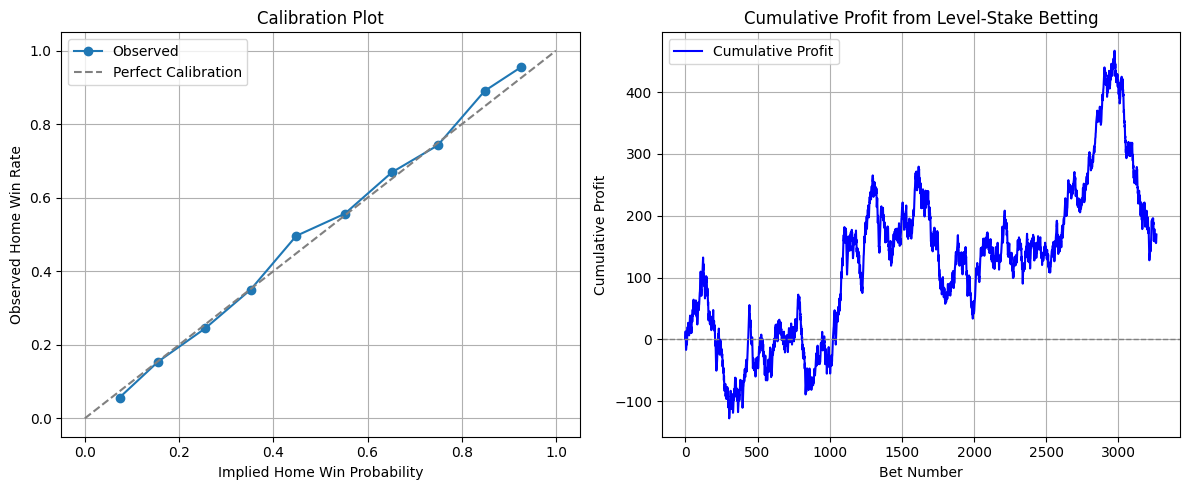

In [ ]:
# Get fair odds - Normalized odds
fair_odds, fair_probs = calculate_weighted_implied_probabilities(data[['Home Odds', 'Away Odds']].copy())

# Build figure and axes for plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Get Brier Score
brier_score = calculate_brier_score(fair_probs, data["Outcomes"])
print(f"Brier Score: {brier_score:.4f}")

# Plot calibration curve
plot_calibration_curve(fair_odds, data["Outcomes"], ax=axs[0])

# Get profit from betting on favourites
profits, total_wins = simulate_favourite_betting_strategy(fair_odds, fair_probs, data["Outcomes"])
print(f"Total Profit from Betting on Favourites: {sum(profits):.2f}")
print(f"Total Wins: {total_wins} out of {len(data)} matches")

# Plot cumulative profit
plot_cumulative_profit(pd.Series(profits), ax=axs[1])

plt.tight_layout()
plt.show()

Brier Score: 0.3873
Total Profit from Betting on Favourites: 169.40
Total Wins: 2280 out of 3264 matches


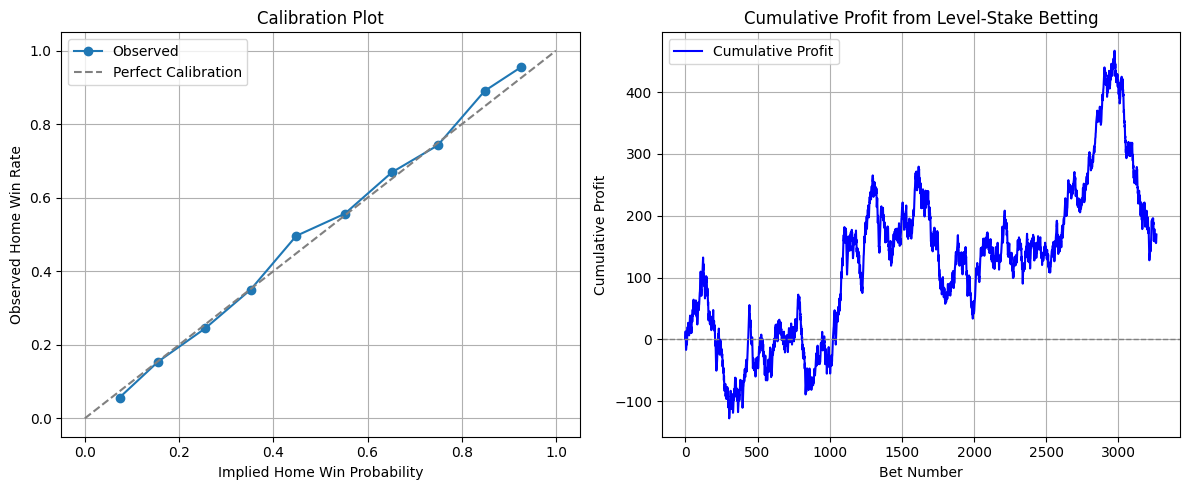

In [29]:
# Get Weighted Odds
fair_odds, fair_probs = calculate_weighted_implied_probabilities(data[['Home Odds', 'Away Odds']].copy())

# Build figure and axes for plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Get Brier Score
brier_score = calculate_brier_score(fair_probs, data["Outcomes"])
print(f"Brier Score: {brier_score:.4f}")

# Plot calibration curve
plot_calibration_curve(fair_odds, data["Outcomes"], ax=axs[0])

# Get profit from betting on favourites
profits, total_wins = simulate_favourite_betting_strategy(fair_odds, fair_probs, data["Outcomes"])
print(f"Total Profit from Betting on Favourites: {sum(profits):.2f}")
print(f"Total Wins: {total_wins} out of {len(data)} matches")

# Plot cumulative profit
plot_cumulative_profit(pd.Series(profits), ax=axs[1])

plt.tight_layout()
plt.show()

Brier Score: 0.3890


AssertionError: 

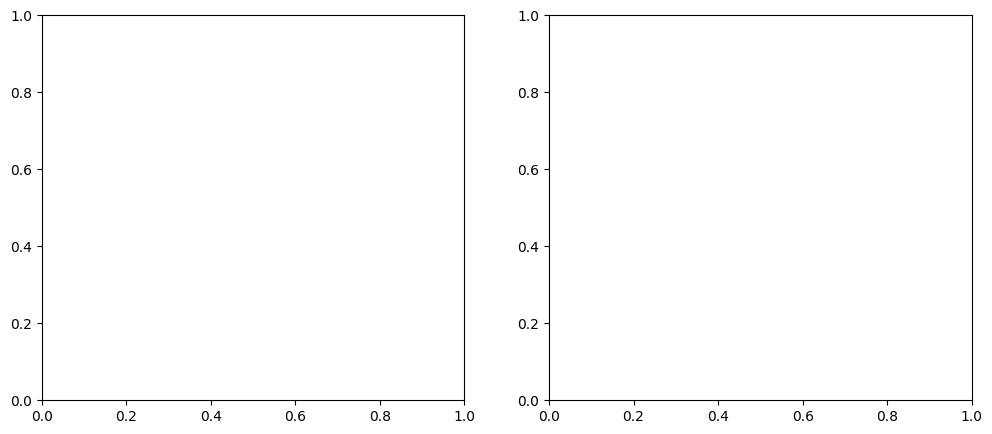

In [ ]:
# Get Actual Odds 
actual_odds = data[['Home Odds', 'Away Odds']].copy()
actual_probs = 1 / actual_odds 
actual_probs.columns = ['Home Probs', 'Away Probs'] 
# Build figure and axes for plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Get Brier Score
brier_score = calculate_brier_score(actual_probs, data["Outcomes"])
print(f"Brier Score: {brier_score:.4f}")

# Plot calibration curve
plot_calibration_curve(actual_odds, data["Outcomes"], ax=axs[0])

# Get profit from betting on favourites
profits, total_wins = simulate_favourite_betting_strategy(actual_odds, actual_probs, data["Outcomes"])
print(f"Total Profit from Betting on Favourites: {sum(profits):.2f}")
print(f"Total Wins: {total_wins} out of {len(data)} matches")

# Plot cumulative profit
plot_cumulative_profit(pd.Series(profits), ax=axs[1])

plt.tight_layout()
plt.show()